In [1]:
#load images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import matplotlib.pyplot as plt 
from PIL import Image
import os
%matplotlib inline

2023-08-30 20:37:34.230483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 20:37:34.346045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-30 20:37:34.346062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-30 20:37:34.370204: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-30 20:37:35.186867: W tensorflow/stream_executor/platform/de

### Load images

In [2]:
batch_size = 16
train_data_dir = "raw_data/training-data-binary-clean-dirt/"
test_data_dir = "raw_data/test-data-binary-clean-dirt/"

train_data = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "binary",
  #class_names = ['clean','dust'],  
  seed=123,
  image_size=(225, 225),
  batch_size=batch_size,
  #validation_split=0.2,
  #subset='both'
) 

val_data = image_dataset_from_directory(
  test_data_dir,
  labels = "inferred",
  label_mode = "binary",
  #class_names = ['clean','dust'],  
  seed=123,
  image_size=(225, 225),
  batch_size=batch_size,
  #validation_split=0.2,
  #subset='both'
) 

#train_data = train_ds[0]
#val_data = train_ds[1]

Found 601 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


2023-08-30 20:37:37.137248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-30 20:37:37.137287: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-30 20:37:37.137302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-JJG0M1AU): /proc/driver/nvidia/version does not exist
2023-08-30 20:37:37.137567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
classes_train = train_data.class_names
classes_train

['clean', 'dirt_damage']

In [4]:
classes = val_data.class_names
classes

['clean', 'dirt_damage']

### Binary model: Clean vs Snow

In [5]:
# We'll use a model with the same convolutional layers, but we'll add Augmentation layers before that

model_clean_dirt = Sequential()

model_clean_dirt.add(layers.Rescaling(1./255, input_shape = (225, 225, 3)))

# Data Augmentation Layers

model_clean_dirt.add(layers.RandomFlip("horizontal"))
model_clean_dirt.add(layers.RandomZoom(0.1))
model_clean_dirt.add(layers.RandomTranslation(0.2, 0.2))
model_clean_dirt.add(layers.RandomRotation(0.1))


# Convolutional Layers

model_clean_dirt.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model_clean_dirt.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_clean_dirt.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_clean_dirt.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_clean_dirt.add(layers.Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_clean_dirt.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_clean_dirt.add(layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_clean_dirt.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_clean_dirt.add(layers.Flatten())

model_clean_dirt.add(layers.Dense(64, activation="relu"))

model_clean_dirt.add(layers.Dropout(0.5))

model_clean_dirt.add(layers.Dense(1, activation="sigmoid"))

In [6]:
adam = optimizers.Adam(learning_rate = 0.001)

model_clean_dirt.compile(loss= 'binary_crossentropy', #'categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

In [7]:
MODEL = "model_clean_dirt"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [8]:
%%time

history_clean_dirt = model_clean_dirt.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper]
        )

Epoch 1/30
38/38 [==============================] - 29s 635ms/step - loss: 0.6147 - accuracy: 0.7621 - val_loss: 0.6808 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
38/38 [==============================] - 24s 625ms/step - loss: 0.5456 - accuracy: 0.7671 - val_loss: 0.6321 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 3/30
38/38 [==============================] - 25s 649ms/step - loss: 0.4926 - accuracy: 0.7737 - val_loss: 0.7498 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/30
38/38 [==============================] - 26s 684ms/step - loss: 0.5004 - accuracy: 0.7887 - val_loss: 0.5428 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 5/30
38/38 [==============================] - 27s 690ms/step - loss: 0.4947 - accuracy: 0.7854 - val_loss: 0.4902 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 6/30
38/38 [==============================] - 27s 713ms/step - loss: 0.4538 - accuracy: 0.7937 - val_loss: 0.5519 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 7/30
38/38 [==============================] - 30s 791ms/st

In [9]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

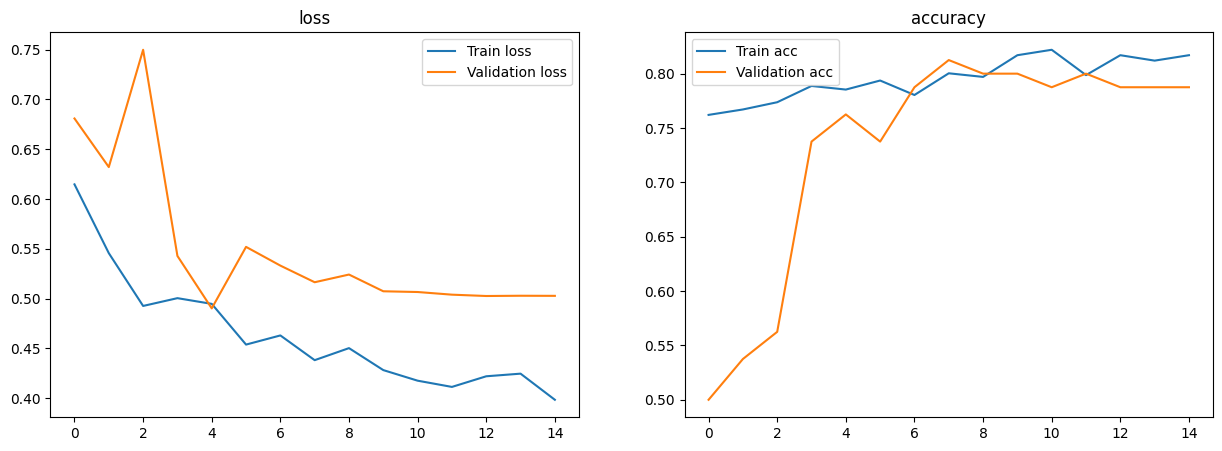

In [10]:
plot_history(history_clean_dirt)

### Pred tests

In [11]:
def predictImage_binary(url, model):

  # Takes an imafe and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  print(f"{res[0]}")  
  res = model.predict(img)[0][0]
  if(res < 0.5):
    pred_class = "clean"
    prob = 1-res
  if(res >= 0.5):
    pred_class = "dirt"
    prob = res

  print("Class : ", pred_class)
  print("probability = ",prob)

In [12]:
# 'img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (4).jpeg", target_size=(225, 225))
# predictImage_binary(img_clean_1,model_clean_snow)
# plt.imshow(img_clean_1);'

In [13]:
# img_clean_2 = load_img(f"raw_data/training-data/clean/Cleaan (15).jpeg", target_size=(225, 225))
# predictImage_binary(img_clean_2,model_clean_snow)
# plt.imshow(img_clean_2);

In [14]:
# img_clean_2 = load_img(f"raw_data/training-data/solar/Solar (15).jpeg", target_size=(225, 225))
# predictImage_binary(img_clean_2,model_clean_snow)
# plt.imshow(img_clean_2);

In [15]:
# img_clean_2 = load_img(f"raw_data/training-data/solar/Solar (21).jpeg", target_size=(225, 225))
# predictImage_binary(img_clean_2,model_clean_snow)
# plt.imshow(img_clean_2);

In [16]:
# img_clean_2 = load_img(f"raw_data/training-data/solar/Solar (28).jpeg", target_size=(225, 225))
# predictImage_binary(img_clean_2,model_clean_snow)
# plt.imshow(img_clean_2);

## Precision, recall

In [17]:
import numpy as np
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report


predictions = np.array([])
probabilities = np.array([])
labels =  np.array([])

for x, y in val_data:
    
  proba = model_clean_dirt.predict(x)
  pred = np.where(proba < 0.5, 0, 1).reshape(len(y))
    
  predictions = np.concatenate([predictions, pred])

  label =  np.squeeze(y) #y.reshape(len(pred))
  proba_damage = np.squeeze(1- proba)  
  prob = proba.reshape(len(y))

  probabilities = np.concatenate([probabilities, proba_damage])  

  labels = np.concatenate([labels, label])  #np.argmax(y.numpy()

report = classification_report(labels, predictions, target_names=classes)

print(report)

1/1 [==============================] - 0s 132ms/step
              precision    recall  f1-score   support

       clean       0.82      0.68      0.74        40
 dirt_damage       0.72      0.85      0.78        40

    accuracy                           0.76        80
   macro avg       0.77      0.76      0.76        80
weighted avg       0.77      0.76      0.76        80



In [18]:
confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[27, 13],
       [ 6, 34]], dtype=int32)

In [19]:
from sklearn.metrics import precision_recall_curve
import pandas as pd

In [20]:
img_clean_2 = load_img(f"{test_data_dir}dirt_damage/Bird (63).jpeg", target_size=(225, 225))
predictImage_binary(img_clean_2,model_clean_dirt)
plt.imshow(img_clean_2);

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/test-data-binary-clean-dirt/dirt_damage/Bird (63).jpeg'